In [1]:
from rlhfutils.eval_utils import oai_kwargs, load_alldfs, annotate_apfarm, apf_format, load_wgpt, filter_and_sort_df
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer
from datasets import load_dataset
import openai
from rlhfutils.data import qaform
from transformers import AutoTokenizer
import pandas as pd
from rlhfutils.eval_utils import getapfsft, tok_dist
import matplotlib.pyplot as plt
from rlhfutils.debug_utils import load_rm, progress_rm
import argparse
import nltk
from nltk.tokenize import sent_tokenize
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from plot_utils import fancyscatter

/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-04 06:07:56,110] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/prasann/miniconda3/envs/stackenv/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/prasann/miniconda3/envs/stackenv/lib/libcudart.so'), PosixPath('/home/prasann/miniconda3/envs/stackenv/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
wgs = load_alldfs("../trl-general/genouts/wgpt//", 400, False)
rlcds = load_alldfs("../trl-general/genouts/rlcdfix/", 800, False)
stacks = load_alldfs("../trl-general/genouts/stack/", 400, False)

generated_wgptthrowlong.jsonl
generated_rlcdtruncboth.jsonl
generated_wgpt4gpu150.jsonl
generated_wgptlenbal.jsonl
generated_wgptmix50_end.jsonl
generated_webgptdappo.jsonl
generated_wgptonew.jsonl
generated_wgptgoodcut.jsonl
generated_wgpthklearly.jsonl
generated_wgptppoorig.jsonl
generated_wgpt4gpu75.jsonl
generated_wgptmix50_highkl.jsonl
generated_wgptlencons.jsonl
generated_wgptthrowlong75.jsonl
generated_wgptnewppo.jsonl
generated_rlcdtruncbad.jsonl
generated_wgptsft.jsonl
generated_wgpthkllate.jsonl
davinciwebgpt.jsonl
generated_wgptlenonly.jsonl
generated_wgptveryrand.jsonl
generated_wgptrwscale.jsonl
generated_webgptdappov250.jsonl
generated_webgptdappov2125.jsonl
generated_wgptnokl.jsonl
generated_wgptboth.jsonl
generated_rlcdlenpen.jsonl
generated_rlcdorigv3.jsonl
generated_rlcdbalancerm.jsonl
generated_rlcdsftv3.jsonl
generated_rlcdrwscale.jsonl
generated_rlcdleftonly.jsonl
generated_rlcdbothcut.jsonl
generated_rlcdrightcut.jsonl
generated_rlcdlenonly.jsonl
generated_rlcdgoo

Token indices sequence length is longer than the specified maximum sequence length for this model (3686 > 2048). Running this sequence through the model will result in indexing errors


generated_stackbig150.jsonl
generated_stacklenonly.jsonl
generated_stackorigrerun.jsonl
generated_stackbalance.jsonl
generated_stacklenonlynokl.jsonl
generated_stackrwscale.jsonl
generated_stackhkl.jsonl
generated_stackbothcut.jsonl
generated_stackda125.jsonl


In [6]:
# given a dataframe, use rm to get rmscos if it doesn't already have them. 
# then bin / mean at intervals of 10 tokens and return lists for a scatter
def score_rm(indf, rm):
    indf['qstrs'] = [qaform(r['question'], r['response']) for _, r in indf.iterrows()]
    rewards = progress_rm(list(indf['qstrs']), rm, kwargs)
    scos = [a[0]['score'] for a in rewards]
    indf['rewards'] = scos

In [4]:
rlcds['rlcdsftv3']['question'][0]

KeyError: 'rlcdsftv3'

In [ ]:
# webgpt get stuff for figures
#adfs = load_alldfs("../trl-general/genouts/wgpt//")
tok, rm, kwargs = load_rm("/home/prasann/Projects/rlhf-exploration/webgpt-llama/models/rewardmodel", 0)

In [7]:
score_dfs = ['wgptrwscale', 'wgptsft', 'wgptppoorig', 'wgpthkllate', 'wgptthrowlong']
# score_dfs = ['wgptsft', 'wgptppoorig', 'wgpthkllate']
for s in score_dfs:
    score_rm(wgs[s], rm)

  0%|                                                                                                                                         | 0/13 [00:00<?, ?it/s]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 10/13 [00:32<00:07,  2.49s/it]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please

In [ ]:
# stack get stuff for figures
tok, rm, kwargs = load_rm("/mnt/data1/prasann/rlhf-exploration/stack-llama/models/rewardsanity/", 0)
#adfs = load_alldfs("../trl-general/genouts/stack/")
score_dfs = ['stacksft', 'stackorigrerun', 'stackhkl']
for s in score_dfs:
    score_rm(stacks[s], rm)

In [17]:
rlcds.keys()

dict_keys(['rlcdlenpen', 'rlcdorigv3', 'rlcdbalancerm', 'rlcdsftv3', 'rlcdrwscale', 'rlcdleftonly', 'rlcdbothcut', 'rlcdrightcut', 'rlcdlenonly', 'rlcdgoodcut', 'rlcdmidcutfix', 'rlcdnokl', 'rlcddiagcut', 'rlcdhkl'])

In [ ]:
# rlcd get stuff for figures
tok, rm, kwargs = load_rm("/home/prasann/Projects/rlhf-exploration/models/rewards/rlcdnormal", 0)

In [ ]:
adfs = load_alldfs("../trl-general/genouts/rlcdfix/")

In [20]:
score_dfs = ['rlcdorigv3', 'rlcdhkl', 'rlcdlenpen', 'rlcdrwscale']
for s in score_dfs:
    score_rm(rlcds[s], rm)

  0%|                                                                                                                                         | 0/25 [00:00<?, ?it/s]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|                                                                                                                                         | 0/25 [00:00<?, ?it/s]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py

In [8]:
rlcdnames = ['rlcdsftv3', 'rlcdhkl', 'rlcdhkl']
stacknames = ['stacksft', 'stackhkl', 'stackhkl']
wgptnames = ['wgptsft', 'wgpthkllate', 'wgpthkllate']

In [6]:
with open('wgptdata.pkl', 'rb') as f:
    wgs = pickle.load(f)
with open('rlcddata.pkl', 'rb') as f:
    rlcds = pickle.load(f)
with open('stackdata.pkl', 'rb') as f:
    stacks = pickle.load(f)

NameError: name 'wgptnames' is not defined

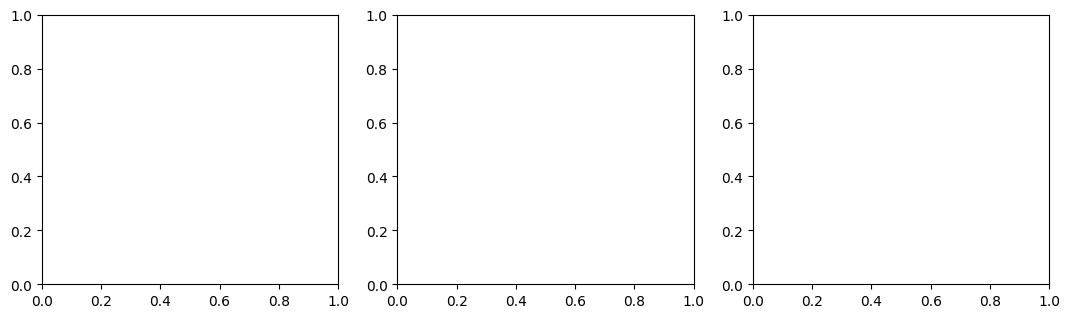

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=False)
# fig.suptitle('Initial Pokemon - 1st Generation')
bwidth = 30
sns.color_palette("deep",8)
hexs = sns.color_palette("deep",8).as_hex()
color_1, color2 = hexs[0], hexs[1]
palette ={'sft': color_1, 'ppo': color2}
fancyscatter(wgptnames, 'W-GPT', wgs, axes[0])
fancyscatter(stacknames, 'Stack', stacks, axes[1])
fancyscatter(rlcdnames, 'RLCD', rlcds, axes[2])
fig.tight_layout()

0.19901870727539062
0.19901870727539062
tots
0.046882306503301004
0.046882306503301004
rats
0.23556733507683764
0.23556733507683764
0.6654835325298888
0.6654835325298888
tots
0.3985158186850646
0.3985158186850646
rats
0.5988364838571961
0.5988364838571961
0.6199930481991522
0.6199930481991522
tots
0.24015099960429287
0.24015099960429287
rats
0.3873446650762321
0.3873446650762321


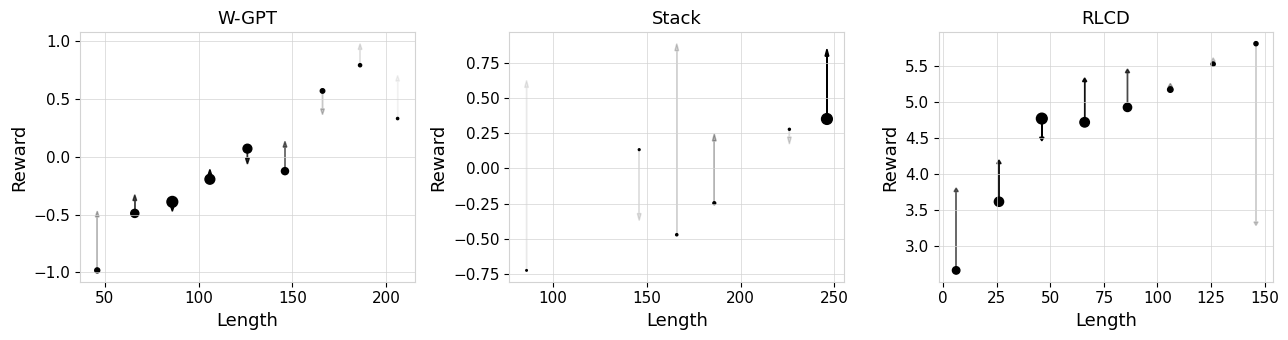

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=False)
# fig.suptitle('Initial Pokemon - 1st Generation')
bwidth = 30
sns.color_palette("deep",8)
hexs = sns.color_palette("deep",8).as_hex()
color_1, color2 = hexs[0], hexs[1]
palette ={'sft': color_1, 'ppo': color2}
fancyscatter(rlcdlenpen, 'Len Penalty', rlcds, axes[0])
fancyscatter(rlcdhkl, 'HKL', rlcds, axes[1])
fancyscatter(rlcdrwscale, 'RW-SC', rlcds, axes[2])
fig.tight_layout()

In [12]:
fig.savefig('hkl_lengthbins.pdf')

In [16]:
import matplotlib as mp

In [23]:
#plt.savefig("arrows/webgptarrows.pdf", format="pdf", bbox_inches="tight")

0.9443442134533901
0.6199930481991522
tots
0.27172030778694534
0.2443641750359471
rats
0.28773439167195847
0.394140185516166


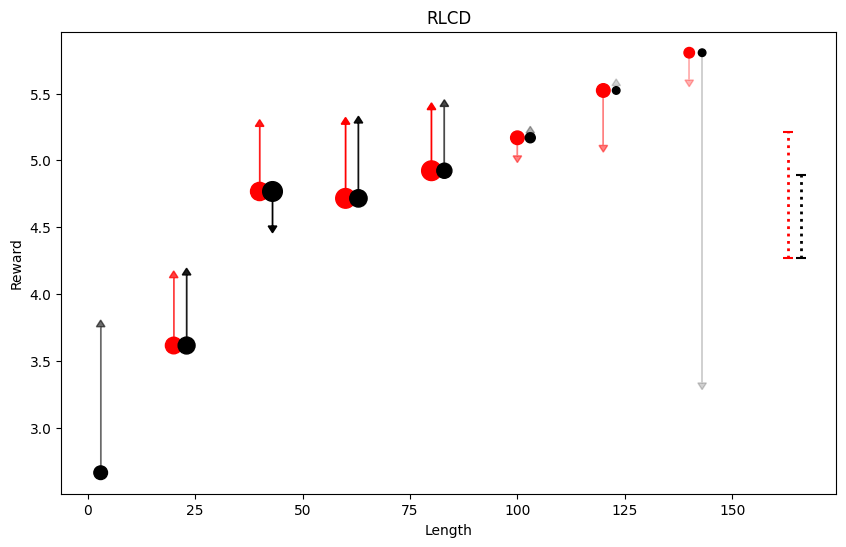

In [77]:
fancyscatter(rlcdnames, 'RLCD', rlcds)
plt.savefig("arrows/rlcdarrows.pdf", format="pdf", bbox_inches="tight")

0.8994966372094974
0.6654835325298888
tots
0.5640851055382163
0.4026455162880186
rats
0.6271119670754678
0.6050420432754053


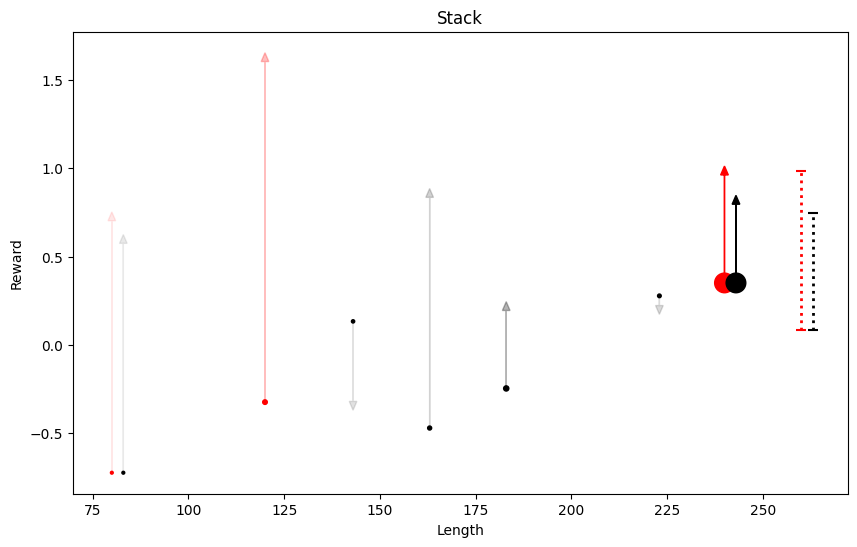

In [75]:
fancyscatter(stacknames, 'Stack', stacks)
plt.savefig("arrows/stackarrows.pdf", format="pdf", bbox_inches="tight")